# A Machine Learning Workflow: Churn Prediction Example

In this post, I will be walking through a machine learning workflow for a customer churn prediction problem. The data is from a ride-sharing company and was pulled on July 1, 2014. Our objective for this post is to ___predict___ customers who are likely to churn so that the company can prevent them from doing so with offers/incentives using `sklearn`.

- _I will extend this example in a separate post later to also help us __explain__ what features may be driving customer churn, which may be equally if not more important for a business than predicting with a fancy model. The next post will be about interpreting model coefficients and feature importances using `statsmodels` and `sklearn`._

For the purposes of this current post, our goal is to predict churn with [optimal](#Metrics-for-Model-Comparison) results.

### Background

A typical machine learning workflow is shown in the image below. There are no universally correct steps to follow - this blog post is just one example. The "art" in the process is mostly at the squiggly part of the line below, as you could go back and forth with testing different models, features, hyperparameters, and error measures. If there is one rule to remember, it's to __split your data__.

It is important to hold out sets of your data that will remain __"unseen"__ by the model at each decision point in order to get an accurate measure of model performance that is not inflated. If we used all of our data to train our model from the start, our model would learn that piece of training data really well (__overfitting__), and may fail to ___generalize___ to other data it has not seen. As your model becomes more complex, training error will monotonically increase while test error will increase to a certain point and then start to decrease once the model starts to overfit.

![train_val_test](images/train_val_test.png)

__Bias-Variance trade-off and overfitting__
<img src="images/bias_variance.png" width="400">

Here's an analogy that stuck from an instructor at Galvanize:


Timmy is learning multiplication. At school, he learns that 3x3 = 9 and 5x5 = 25. The teacher quizzes him on these problems and he gets 100% correct - yay! He goes home and tells his mom that he's learned all there is to know about multiplication. To validate 😏, his mom asks him what 12x13 is. Timmy doesn't know the answer.


The issue here is that Timmy learned (or essentially memorized) very specific cases of multiplication, and thought that he knew because he got a 100% on his school test given those problems (__high training accuracy__). However, when his mom gave him a new "unseen" problem, he could not generalize (__low test accuracy__) because he has not truly learned more general rules of multiplication.

### Tutorial Outline

1. [Loading the Data](#1.-Loading-the-Data)
2. [Handing Missing Values](#2.-Handling-Missing-Values)
3. [Exploratory Data Analysis](#3.-Exploratory-Data-Analysis)
4. [Data Pipeline](#4.-Data-Pipeline)
5. [Model Training and Model Selection](#5.-Model-Training-and-Model-Selection)
6. [Hyperparameter Tuning](#6.-Hyperparameter-Tuning)

### 1. Loading the Data

For this analysis, I will use `pandas` for data manipulation, `matplotlib` and `seaborn` for plotting, and `sklearn` for machine learning. I will also use `sklearn_pandas` and `sklearn.pipeline` to set up our model pipeline.

In [2]:
# Suppress deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
import datetime
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
%matplotlib inline

# Set font size for plotting
sns.set(font_scale=1.5)

In [4]:
df = pd.read_csv('data/churn.csv', parse_dates=['last_trip_date', 'signup_date'])

In [5]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


Let's create a label for churn users (inactive in the last 30 days) for our models to predict.

In [7]:
# 30 days before the data pull date
date_cutoff = df['last_trip_date'].max() - datetime.timedelta(30, 0, 0)

# A retained user is labeled as "churn" if they did not take a trip within 30 days of the data pull date
df['churn'] = (df['last_trip_date'] < date_cutoff).astype(int)

### 2. Handling Missing Values

A few options:
1. Remove all rows with missing values
2. Impute the missing values (with mean, median, mode for a particular feature)
3. Bin variables with missing values and add a level for 'missing'

1 and 2 are appropriate when we are confident that values are missing at random.

We have missing values for `avg_rating_by_driver`, `avg_rating_of_driver`, and `phone` features. First, let's see if values are missing at random by seeing whether there is an effect on user churn. To do this, we can look at whether there is a signicant difference in percent churn users in users who have vs. don't have missing values.

In [8]:
import scipy.stats as scs

def run_ttest(feature, condition):
    '''
    Function to run t-test for a given column from a dataframe.
    
    INPUT feature (pandas series): column of interest
    INPUT condition (boolean): condition to t-test by
    OUTPUT: 
    '''
    ttest = scs.ttest_ind(feature[condition], feature[-condition])
    print '===== T-test for Difference in Means ====='
    print 'User count: {} vs. {}'.format(len(feature[condition]), len(feature[-condition]))
    print 'Mean comparison: {} vs. {}'.format(feature[condition].mean(), feature[-condition].mean())
    print 'T statistic: {}'.format(ttest.statistic, 4)
    print 'p-value: {}'.format(ttest.pvalue)

The few missing `phone` values may be negligible as there was not a significant effect on user churn (p>.05). Given that missing values are random, and there are only 396 missing values out of 50000, we can go ahead and drop rows with missing phone data.

In [9]:
# Effect of missing phone values
run_ttest(df['churn'], df['phone'].isnull())

===== T-test for Difference in Means =====
User count: 396 vs. 49604
Mean comparison: 0.328282828283 vs. 0.366502701395
T statistic: -1.57245036678
p-value: 0.115852468875


In [10]:
# Remove rows where phone values are missing
df = df[df['phone'].notnull()]

It looks like there is an effect of both missing `avg_rating_by_driver` and `avg_rating_of_driver` on user churn.

In [11]:
# Effect of missing ratings by driver
run_ttest(df['churn'], df['avg_rating_by_driver'].isnull())

===== T-test for Difference in Means =====
User count: 198 vs. 49406
Mean comparison: 0.171717171717 vs. 0.367283325912
T statistic: -5.70138430771
p-value: 1.19511322468e-08


In [12]:
# Effect of missing ratings of driver
run_ttest(df['churn'], df['avg_rating_of_driver'].isnull())

===== T-test for Difference in Means =====
User count: 8026 vs. 41578
Mean comparison: 0.194119112883 vs. 0.399778729136
T statistic: -35.4474158072
p-value: 8.06093761267e-272


Since the missing values aren't random, we shouldn't remove or impute rows with missing values. Instead, we can create a categorical variable with 'missing' as a bin. If we look at the distribution of ratings, we see that most people rate a 5. We should try to balance our bins somewhat.

In [13]:
def add_binned_ratings(df, old_col, new_col):
    '''
    Add column for binned ratings.
    
    INPUT:
    - df (full dataframe)
    - old_col (str): column name of average ratings
    - new_col (str): new column name for binned average ratings
    OUTPUT:
    - new dataframe
    '''
    df[new_col] = pd.cut(df[old_col].copy(), bins=[0., 3.99, 4.99, 5],
                            include_lowest=True, right=True)
    df[new_col].cat.add_categories('Missing', inplace=True)
    df[new_col].fillna('Missing', inplace=True)                        
    return df

df = add_binned_ratings(df, 'avg_rating_by_driver', 'bin_avg_rating_by_driver')
df = add_binned_ratings(df, 'avg_rating_of_driver', 'bin_avg_rating_of_driver')

In [16]:
pd.crosstab(df['avg_rating_by_driver'], df['bin_avg_rating_by_driver'])

bin_avg_rating_by_driver,"[0, 3.99]","(3.99, 4.99]","(4.99, 5]",Missing
avg_rating_by_driver,,,,
1.0,180,0,0,0
1.5,4,0,0,0
2.0,126,0,0,0
2.3,1,0,0,0
2.5,31,0,0,0
2.7,2,0,0,0
2.8,3,0,0,0
3.0,598,0,0,0
3.2,2,0,0,0


In [17]:
pd.crosstab(df['avg_rating_by_driver'], df['bin_avg_rating_by_driver'])

bin_avg_rating_by_driver,"[0, 3.99]","(3.99, 4.99]","(4.99, 5]",Missing
avg_rating_by_driver,,,,
1.0,180,0,0,0
1.5,4,0,0,0
2.0,126,0,0,0
2.3,1,0,0,0
2.5,31,0,0,0
2.7,2,0,0,0
2.8,3,0,0,0
3.0,598,0,0,0
3.2,2,0,0,0


In [18]:
# Delete previous rating columns
df.drop(['avg_rating_by_driver', 'avg_rating_of_driver'], axis=1, inplace=True)

### 3. Exploratory Data Analysis

I won't go into EDA extensively here since it was covered in my [last post](http://carmenlai.com/2016/11/05/titanic.html), but it's always good to have some hypotheses in mind before diving into the data.
- Users who use the app more (higher `trips_in_first_30_days` and `weekday_pct`) are probably more likely to remain active
- Users who experience more surge (`avg_surve`) may be less satisfied and more likely to churn
- `luxury_car_user` may be the premium users with higher willingness to pay who are less likely to churn
- Those in less metropolitan areas may be more likely to churn due to lower driver supply
- As we saw from above, most people rate 5's for `avg_rating_by_driver` and `avg_rating_of_driver` and it may be a more passive action as opposed to a meaningful one

__63% of users have churned__.

In [19]:
df['churn'].value_counts()/len(df['churn'])

0    0.633497
1    0.366503
Name: active, dtype: float64

From the __scattermatrix__ below, there does not appear to be any one clear variable that divides churn vs. active users.

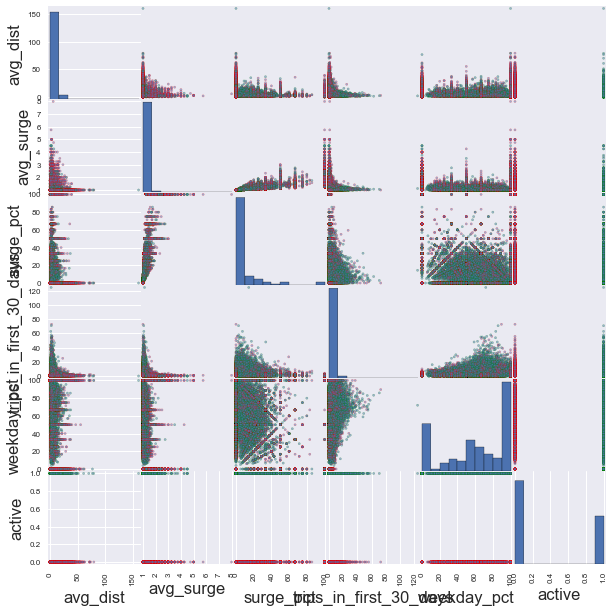

In [20]:
colors = ['green' if x else 'red' for x in df['churn']]

numeric_cols = list(df.dtypes[(df.dtypes=='float') | (df.dtypes=='int')].index.values)

scatter_matrix(df[numeric_cols], figsize=(10, 10), diagonal='hist', color=colors)
plt.show();

### 4. Data Pipeline

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                    49604 non-null float64
avg_surge                   49604 non-null float64
city                        49604 non-null object
last_trip_date              49604 non-null datetime64[ns]
phone                       49604 non-null object
signup_date                 49604 non-null datetime64[ns]
surge_pct                   49604 non-null float64
trips_in_first_30_days      49604 non-null int64
luxury_car_user             49604 non-null bool
weekday_pct                 49604 non-null float64
active                      49604 non-null int64
bin_avg_rating_by_driver    49604 non-null category
bin_avg_rating_of_driver    49604 non-null category
dtypes: bool(1), category(2), datetime64[ns](2), float64(4), int64(2), object(2)
memory usage: 4.3+ MB


No more missing values! To prepare our data for modeling, we need all values to be numeric in order to be valid inputs for `sklearn`. We will have to do some transforms on our __categorical variables__ and create dummy variables. Here's an illustration of what this means:

In [22]:
x = df['city'].head()
dummies = pd.get_dummies(x, prefix='city')
pd.concat([x, dummies], axis=1)

,city,city_Astapor,city_King's Landing,city_Winterfell
0,King's Landing,0.0,1.0,0.0
1,Astapor,1.0,0.0,0.0
2,Astapor,1.0,0.0,0.0
3,King's Landing,0.0,1.0,0.0
4,Winterfell,0.0,0.0,1.0


#### Using a pipeline for data transformations and scaling

__Transformations__ - another way to do the above is by using a transformer from `sklearn.preprocessing` called `LabelBinarizer`. Rather than doing these transformations one by one and then stitching everything back together, I am going to create a pipeline using a combination of [`sklearn-pandas`](https://github.com/paulgb/sklearn-pandas) and [`sklearn's pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to organize the steps in my data transformations. `sklearn-pandas` is great for doing __transformations on specific columns__ from a dataframe. More on the differences between the two libraries [here](https://stackoverflow.com/questions/40352176/whats-the-difference-between-sklearn-pipeline-and-dataframemapper).

__Scaling__ or standardizing your data is important when your variables have units on different orders of magnitude - you want to standardize values so that variables with a bigger unit don't drown out smaller ones. _(Example: determining key predictors of how quickly a house will sell - number of bedrooms vs. sale price in dollars)_

It is good practice to use a pipeline for machine learning because it
1. Keeps track of all the transformations and scaling that you do on your data
2. Easily __applies any processing you did on your training set to your test set__ (remember these from a few paragraphs ago?)

Remember that our test set needs to remain completely unseen by any of our modeling - this applies to scaling the data as well. You can think of scaling as part of our modeling. Whatever mean and standard deviation we use to scale the training data, we need to use to scale the test data in model validation. Pipeline makes this easy.

In [23]:
# Create dataframe mapper in preparation for sklearn modeling, which takes numeric numpy arrays
mapper = DataFrameMapper([
        ('avg_dist', None),
        ('avg_surge', None),
        ('city', LabelBinarizer()),
        ('phone', LabelBinarizer()),
        ('surge_pct', None),
        ('trips_in_first_30_days', None),
        ('luxury_car_user', LabelEncoder()),
        ('weekday_pct', None),
        ('bin_avg_rating_by_driver', LabelBinarizer()),
        ('bin_avg_rating_of_driver', LabelBinarizer()),
])

Here's an example of a pipeline that we'll incorporate later in our modeling.

In [24]:
lr_pipeline = Pipeline([
        ('featurize', mapper),
        ('scale', StandardScaler()),
        ('classifier', LogisticRegression())
        ])

# We can use this as if it were our model:
# lr_pipeline.fit(X_train, y_train)
# lr_pipeline.predict(X_test, y_test)
# etc...

### 5. Model Training and Model Selection

First, we'll split our variables into features (X) and labels (y), and split our data into a training (80%) and test (20%) set.

In [25]:
X = df.copy()
y = X.pop('churn')

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

#### __Metrics for Model Comparison__

1. __Test accuracy__ - how many times the model gets it right (true positives and true negatives). We have relatively balanced classes with churn vs. active users, but if we had more imbalanced classes (like in the case of predicting a rare disease), we may want to consider both precision and recall rather than just accuracy. A good measure that accounts for both precision and recall is the F1 score. For our example, we will use accuracy.
<br>
<br>
2. __ROC plot and AUC (area under the curve)__ - shows the trade-off between __true positive rate (sensitivity)__ and __false positive rate__. We will use this to compare models. Typically, the model with a higher AUC value (a curve that is closer towards the upper left corner of the plot) is the "better" model and you want to pick the threshold at the elbow of the curve. However, the "better" model could also depend on our __tolerance for false positives__. In the example below, the red and black curves are from 2 different models. If we require a lower false positive rate, the red model would be the better choice. If we don't mind a higher false positive rate, the black model may be better. [See below for our churn prediction ROC plot.](#3.-ROC-plot)
<img src="images/roc_example.jpg" width="350">
<br>
3. __Profit curve__ - takes into account dollar costs/benefits associated with true positives, false positives, true negatives, and false negatives. A profit curve can help optimize overall profit and help you select the best __model__ and __predicted probability threshold__. What's the cost to the company of your model predicts incorrectly? What's the added value if it predicts correctly? etc. [See more detail below for our churn prediction example.](#4.-Profit-curve)
<img src="images/profit_example.png" width="400">

Accuracy is already available through `sklearn`. We will have to write functions for the ROC plot and profit curves.

#### ROC Plot Functions

In [27]:
def roc_curve(y_proba, y_test):
    '''
    Return the True Positive Rates, False Positive Rates and Thresholds for the
    ROC curve plot.
    
    INPUT y_proba (numpy array): predicted probabilities
    INPUT y_test (numpy array): true labels
    OUTPUT (lists): lists of true positive rates, false positive rates, thresholds 
    '''

    thresholds = np.sort(y_proba)

    tprs = []
    fprs = []

    num_positive_cases = sum(y_test)
    num_negative_cases = len(y_test) - num_positive_cases

    for threshold in thresholds:
        # With this threshold, give the prediction of each instance
        predicted_positive = y_proba >= threshold
        # Calculate the number of correctly predicted positive cases
        true_positives = np.sum(predicted_positive * y_test)
        # Calculate the number of incorrectly predicted positive cases
        false_positives = np.sum(predicted_positive) - true_positives
        # Calculate the True Positive Rate
        tpr = true_positives / float(num_positive_cases)
        # Calculate the False Positive Rate
        fpr = false_positives / float(num_negative_cases)

        fprs.append(fpr)
        tprs.append(tpr)
    
    return tprs, fprs, thresholds.tolist()

def plot_roc_curve(pipeline, y_pred, y_proba, y_test):
    '''
    Plot ROC curve with data from function above.
    '''
    tpr, fpr, thresholds = roc_curve(y_proba, y_test)

    model_name = pipeline.named_steps['classifier'].__class__.__name__
    auc = round(roc_auc_score(y_test, y_pred), 3)
    plt.plot(fpr, tpr, label='{}, AUC: {}'.format(model_name, auc))

#### Profit Curve Functions

In [44]:
def standard_confusion_matrix(y_true, y_pred):
    '''
    Reformat confusion matrix output from sklearn for plotting profit curve.
    '''
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

def plot_profit_curve(pipeline, costbenefit_mat, y_proba, y_test):
    '''
    Plot profit curve.
    
    INPUTS:
    - model object
    - cost benefit matrix in the same format as the confusion matrix above
    - predicted probabilities
    - actual labels
    ''' 

    # Profit curve data
    profits = [] # one profit value for each T (threshold)
    thresholds = sorted(y_proba, reverse=True)
    
    # For each threshold, calculate profit - starting with largest threshold
    for T in thresholds:
        y_pred = (y_proba > T).astype(int)
        confusion_mat = standard_confusion_matrix(y_test, y_pred)
        # Calculate total profit for this threshold
        profit = sum(sum(confusion_mat * costbenefit_mat)) / len(y_test)
        profits.append(profit)
    
    # Profit curve plot
    model_name = pipeline.named_steps['classifier'].__class__.__name__
    max_profit = max(profits)
    plt.plot(np.linspace(0, 1, len(y_test)), profits, label = '{}, max profit ${} per user'.format(model_name, max_profit))

#### Model Classifier Object
I will store our models in a __class object__ for easier model comparison. Note that it's generally good to start with a simple model (logistic regression) before jumping into more complex ones (random forest) to establish baseline performance. For instance, in some cases, simply predicting the outcome label with the mean of a feature could potentially perform better than a fancy random forest model.

In [29]:
class Classifiers(object):
    '''
    Classifier object for fitting, storing, and comparing multiple model outputs.
    '''

    def __init__(self, classifier_list):
        
        self.classifiers = classifier_list
        self.classifier_names = [est.__class__.__name__ for est in self.classifiers]
        
        # List to store pipeline objects for classifiers
        self.pipelines = []

    def create_pipelines(self, mapper):
        
        for classifier in self.classifiers:
            self.pipelines.append(Pipeline([
                ('featurize', mapper),
                ('scale', StandardScaler()),
                ('classifier', classifier)
                ]))
    
    
    def train(self, X_train, y_train):
        
        for pipeline in self.pipelines:
            pipeline.fit(X_train, y_train)
        
    
    def accuracy_scores(self, X_test, y_test):
        
        # Lists to store classifier test scores
        self.accuracies = []

        for pipeline in self.pipelines:            
            self.accuracies.append(pipeline.score(X_test, y_test))

        # Print results
        accuracy_df = pd.DataFrame(zip(self.classifier_names, self.accuracies))
        accuracy_df.columns = ['Classifier', 'Test Accuracies']
        
        print accuracy_df
            

    def plot_roc_curve(self, X_test, y_test):
    
        # Plot ROC curve for each classifier
        plt.figure(figsize=(10, 10))
        for pipeline in self.pipelines:
            y_pred = pipeline.predict(X_test)
            y_proba = pipeline.predict_proba(X_test)[:, 1]
            plot_roc_curve(pipeline, y_pred, y_proba, y_test)

        # 45 degree line
        x = np.linspace(0, 1.0, 20)
        plt.plot(x, x, color='grey', ls='--')
        
        # Plot labels
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity, Recall)')
        plt.title('ROC Plots')
        plt.legend(loc='lower right')
        plt.show()

        
    def plot_profit_curve(self, costbenefit_mat, X_test, y_test):
        
        # Plot profit curve for each classifier
        plt.figure(figsize=(10, 10))
        for pipeline in self.pipelines:
            y_proba = pipeline.predict_proba(X_test)[:, 1]
            plot_profit_curve(pipeline, costbenefit_mat, y_proba, y_test)
            
        # Plot labels
        plt.xlabel('Percentage of test instances (decreasing by score)')
        plt.ylabel('Profit')
        plt.title('Profit Curves')
        plt.legend(loc='lower left')
        plt.show()        

Those are all the function definitions. __Now let's compare 3 models: logistic regression, random forest, and gradient boosting.__

#### 1. Train the models

In [30]:
# List of classifiers
lr = LogisticRegression()
rf = RandomForestClassifier(n_jobs=-1)
gb = GradientBoostingClassifier()

clfs = Classifiers([lr, rf, gb])

In [31]:
clfs.create_pipelines(mapper)

In [32]:
clfs.train(X_train, y_train)

#### 2. Test accuracy

In [33]:
clfs.accuracy_scores(X_test, y_test)

                   Classifier  Test Accuracies
0          LogisticRegression         0.762524
1      RandomForestClassifier         0.754561
2  GradientBoostingClassifier         0.795384


#### 3. ROC plot

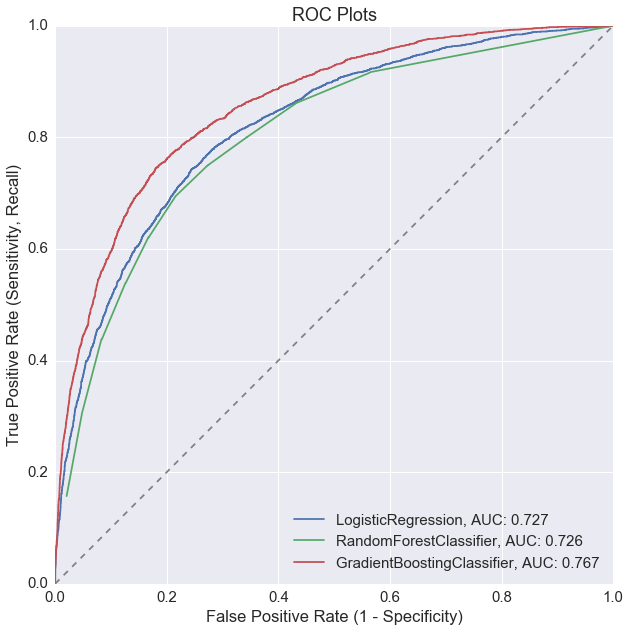

In [34]:
clfs.plot_roc_curve(X_test, y_test)

#### 4. Profit curve

The cost benefit matrix defined here is in dollars, in the following format:

||Actual +|Actual -|
|-----------|-------------|--------------|
|__Predicted +__|True Positive|False Positive|
|__Predicted -__|False Negative|True Negative|

__Cost benefit matrix__

We will assume that if the model predicts that a user will churn, we will spend \$150 dollars retaining them (in promotions, marketing, etc.). If the model does not predict when a user churns, we will lose an estimated \$325 in customer lifetime value. If we successfully identify a customer who will churn and manage to retain them, we will gain in customer lifetime value minus the cost of retaining them (\$325 - \$150).

||Actual +|Actual -|
|-----------|------------------------|----------------------|
|__Predicted +__|Correctly Predict Churn<br>__\$175__|Falsely Predict Churn<br>__-\$150__|
|__Predicted -__|Falsely Predict Active<br>__-\$325__|Correctly Predict Active<br>__\$0__|

In [55]:
# Define cost-benefit matrix with input from business managers, other stakeholders, etc.
costbenefit_mat = np.array([[0, 0],
                            [-150, 175]])

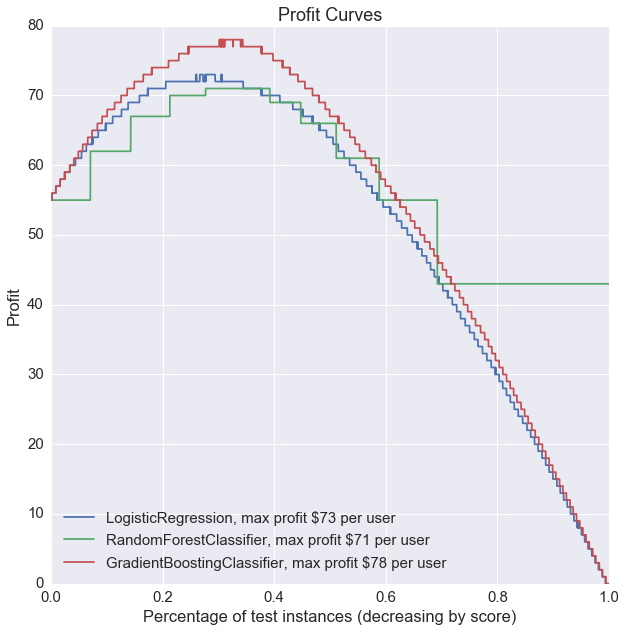

In [56]:
# Plot profit curves
clfs.plot_profit_curve(costbenefit_mat, X_test, y_test)

__Gradient boosting seems to be the best performer__ based on all 3 of our metrics: highest test accuracy, ROC curve with highest AUC, and highest profit. This is without any model tuning.

### 6. Hyperparameter Tuning

`GridSearchCV` is a brut-force way of optimizing our model parameters like learning rate, tree size, etc. It runs through each combination of __search parameters__ you specify, and compares them based on a specified __scoring method__ ('accuracy', 'f1', 'roc_auc', etc.).

Tuning the gradient boosting parameters:

In [ ]:
# To grid search a pipeline object, you need to specify the step in pipeline,
# followed by paramater name. Example => 'step__parameter_name': [1, 2]

gb_params = {
    'classifier__learning_rate': [1.0, 0.01],
    'classifier__max_depth': [1, 6, 8],
    'classifier__min_samples_leaf': [2],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__n_estimators': [500, 1000],
    'classifier__subsample': [0.25, 0.5]
}

gb_pipeline = Pipeline([
                ('featurize', mapper),
                ('scale', StandardScaler()),
                ('classifier', GradientBoostingClassifier())
                ])

gb_grid = GridSearchCV(gb_pipeline, gb_params, scoring='accuracy') # scoring could also be 'f1', 'roc_auc', etc.
gb_grid = gb_grid.fit(X_train, y_train)

best_gb_model = gb_grid.best_estimator_
best_gb_params = gb_grid.best_params_

Tuning the random forest parameters:

In [ ]:
rf_params = {
    'classifier__max_depth': [4, 8, None],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__min_samples_split': [1, 2, 4],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True], # Mandatory with oob_score=True
    'classifier__n_estimators': [50, 100, 200, 400],
    'classifier__random_state': [67],
    'classifier__oob_score': [True],
    'classifier__n_jobs': [-1]
    }

rf_pipeline = Pipeline([
                ('featurize', mapper),
                ('scale', StandardScaler()),
                ('classifier', RandomForestClassifier())
                ])

rf_grid = GridSearchCV(rf_pipeline, rf_params, scoring='accuracy') # scoring could also be 'f1', 'roc_auc', etc.
rf_grid = rf_grid.fit(X_train, y_train)

best_rf_model = rf_grid.best_estimator_
best_rf_params = rf_grid.best_params_

Now we can repeat what we did above with the best parameters.

In [47]:
# Rebuild classifiers with best parameters from grid search
gb_params = {'learning_rate': 0.01,
             'max_depth': 6,
             'max_features': None,
             'min_samples_leaf': 2,
             'n_estimators': 1000,
             'subsample': 0.25}

rf_params = {'bootstrap': True,
     'max_depth': 8,
     'max_features': None,
     'min_samples_leaf': 2,
     'min_samples_split': 1,
     'n_estimators': 400,
     'n_jobs': -1,
     'oob_score': True,
     'random_state': 67}

# List of classifiers
lr = LogisticRegression()
rf_tuned = RandomForestClassifier(**rf_params)
gb_tuned = GradientBoostingClassifier(**gb_params)

In [48]:
clfs_tuned = Classifiers([lr, rf_tuned, gb_tuned])

In [49]:
clfs_tuned.create_pipelines(mapper)

In [50]:
clfs_tuned.train(X_train, y_train)

In [51]:
clfs_tuned.accuracy_scores(X_test, y_test)

                   Classifier  Test Accuracies
0          LogisticRegression         0.762524
1      RandomForestClassifier         0.790041
2  GradientBoostingClassifier         0.801028


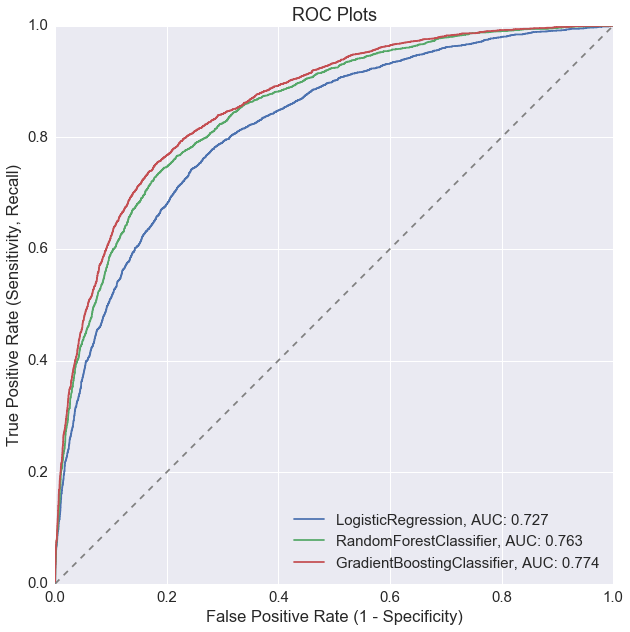

In [52]:
clfs_tuned.plot_roc_curve(X_test, y_test)

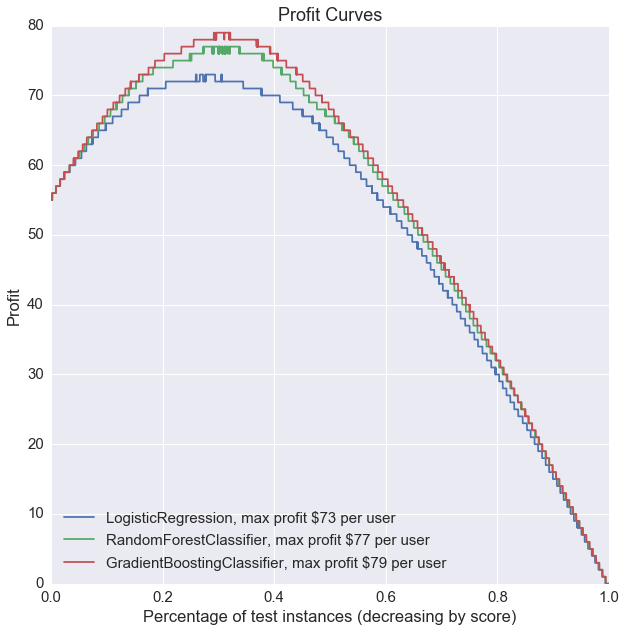

In [57]:
clfs_tuned.plot_profit_curve(costbenefit_mat, X_test, y_test)

Model tuning improved the __random forest__ model the most, but overall, the __gradient boosting__ model is still our best performer for churn prediction.